<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with ResNet Architecture  - Transfer Learning alog with Hyperparameter Tuning</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/Model Training/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [3]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize
from predictions import predict_image_class

**Importing Libraries**

In [4]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


In [5]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'
path_to_save_model=r"/content/drive/MyDrive/AI Project/Model Training/Satellite_datatset_weights/"
file_name = "satellite_dataset_RESNET" 

**Set the hyperparameters**

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

Device: cuda:0


In [7]:
#grid search
hyper_parameters = {"learning_rate": [0.01, 0.001, 0.0001], "optimizers": ['Adam', 'SGD']}

train_loss_hyper_parameters = {"lr0.01Adam": [], "lr0.001Adam": [], "lr0.0001Adam": [], "lr0.01SGD": [], "lr0.001SGD": [], "lr0.0001SGD": []}
train_acc_hyper_parameters = {"lr0.01Adam": [], "lr0.001Adam": [], "lr0.0001Adam": [], "lr0.01SGD": [], "lr0.001SGD": [], "lr0.0001SGD": []}

val_loss_hyper_parameters = {"lr0.01Adam": [], "lr0.001Adam": [], "lr0.0001Adam": [], "lr0.01SGD": [], "lr0.001SGD": [], "lr0.0001SGD": []}
val_acc_hyper_parameters = {"lr0.01Adam": [], "lr0.001Adam": [], "lr0.0001Adam": [], "lr0.01SGD": [], "lr0.001SGD": [], "lr0.0001SGD": []}


num_epochs=12

########### LEARNING RATE ##################
for learning_rate in hyper_parameters["learning_rate"]:    

    ########### Define the optimiser ###############
    for optimizer_name in hyper_parameters["optimizers"]:
      
      print("Results of the Optimizer ", optimizer_name, " with Learning Rate ", learning_rate, "\n")

      ############ Load the dataset ###########
      train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.2, val_split=0.1, batch_size=32, input_size=[64,64])
      label_encoding = data.class_to_idx  
      print("label mapping is ", label_encoding, "\n") 

      ########### Load the Pre-trained Model ###########
      model = models.resnet50(weights=True) 
      # freeze pre-trained layers
      for param in model.parameters(): 
        param.requires_grad = False

      # re-define the final fully-connected layer, and this one will be trained with the dataset
      # num_classes = 4
      model.fc = nn.Sequential(nn.Linear(2048, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.2),
                                      nn.Linear(512, 4))
    
      ######### Loss, Early Stopping and Optimizer with LR Scheduler ###############
      criterion = nn.CrossEntropyLoss() 
      early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

      if optimizer_name == "Adam":
        #Adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
      else:
        # SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)


      ############ Call the train function ###########
      model.to(device)
      minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(model=model,
                                                    num_epochs=num_epochs,
                                                    train_loader=train_loader,
                                                    valid_loader=valid_loader,
                                                    criterion = criterion,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    early_stopping=early_stopping,
                                                    file_name = file_name,
                                                    path_to_save_model=path_to_save_model,
                                                    scheduler=scheduler) 

      ############ Store train_loss, and train_accuracy in the defined dictionaries ###########
      train_loss_hyper_parameters[f'lr{learning_rate}{optimizer_name}'] = train_loss_list
      train_acc_hyper_parameters[f'lr{learning_rate}{optimizer_name}'] = train_acc_list

      val_loss_hyper_parameters[f'lr{learning_rate}{optimizer_name}'] = valid_loss_list
      val_acc_hyper_parameters[f'lr{learning_rate}{optimizer_name}'] = valid_acc_list


      test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=device)
      print(f'Test Accuracy {test_acc :.2f}%')
      print(f'Test Loss {test_loss :.4f}')

      print("CONFUSION MATRIX")
      print(compute_classification_report(test_loader, model, device=device))

      print("-"*60, "\n\n")

Results of the Optimizer  Adam  with Learning Rate  0.01 

label mapping is  {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3} 



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch: 001/012 | Batch 0000/0124 | Loss: 1.4353
Epoch: 001/012 | Batch 0100/0124 | Loss: 0.3369
Epoch: 001/012 | Train ACC: 48.44% | Validation ACC: 89.88%| Train LOSS: 1.1506| Validation LOSS: 0.2986
Time elapsed: 22.88 min
Epoch: 002/012 | Batch 0000/0124 | Loss: 0.5780
Epoch: 002/012 | Batch 0100/0124 | Loss: 0.2633
Epoch: 002/012 | Train ACC: 85.94% | Validation ACC: 87.03%| Train LOSS: 0.4482| Validation LOSS: 0.3454
Time elapsed: 23.13 min
Epoch: 003/012 | Batch 0000/0124 | Loss: 0.5041
Epoch: 003/012 | Batch 0100/0124 | Loss: 0.2613
Epoch: 003/012 | Train ACC: 87.50% | Validation ACC: 92.36%| Train LOSS: 0.3824| Validation LOSS: 0.2382
Time elapsed: 23.39 min
Epoch: 004/012 | Batch 0000/0124 | Loss: 0.1753
Epoch: 004/012 | Batch 0100/0124 | Loss: 0.4077
Epoch: 004/012 | Train ACC: 92.19% | Validation ACC: 92.01%| Train LOSS: 0.3366| Validation LOSS: 0.2291
Time elapsed: 23.64 min
Epoch: 005/012 | Batch 0000/0124 | Loss: 0.1514
Epoch: 005/012 | Batch 0100/0124 | Loss: 0.4990
Epoc

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/012 | Batch 0000/0124 | Loss: 1.4108
Epoch: 001/012 | Batch 0100/0124 | Loss: 0.3981
Epoch: 001/012 | Train ACC: 57.81% | Validation ACC: 87.39%| Train LOSS: 0.6400| Validation LOSS: 0.3433
Time elapsed: 0.28 min
Epoch: 002/012 | Batch 0000/0124 | Loss: 0.9426
Epoch: 002/012 | Batch 0100/0124 | Loss: 0.3210
Epoch: 002/012 | Train ACC: 78.12% | Validation ACC: 87.92%| Train LOSS: 0.3790| Validation LOSS: 0.2997
Time elapsed: 0.53 min
Epoch: 003/012 | Batch 0000/0124 | Loss: 0.4024
Epoch: 003/012 | Batch 0100/0124 | Loss: 0.2271
Epoch: 003/012 | Train ACC: 89.06% | Validation ACC: 93.96%| Train LOSS: 0.3095| Validation LOSS: 0.1976
Time elapsed: 0.79 min
Epoch: 004/012 | Batch 0000/0124 | Loss: 0.2317
Epoch: 004/012 | Batch 0100/0124 | Loss: 0.1906
Epoch: 004/012 | Train ACC: 90.62% | Validation ACC: 90.59%| Train LOSS: 0.2867| Validation LOSS: 0.2371
Time elapsed: 1.05 min
Epoch: 005/012 | Batch 0000/0124 | Loss: 0.3183
Epoch: 005/012 | Batch 0100/0124 | Loss: 0.5034
Epoch: 0

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/012 | Batch 0000/0124 | Loss: 1.4046
Epoch: 001/012 | Batch 0100/0124 | Loss: 0.6476
Epoch: 001/012 | Train ACC: 42.19% | Validation ACC: 89.17%| Train LOSS: 0.5998| Validation LOSS: 0.3125
Time elapsed: 0.27 min
Epoch: 002/012 | Batch 0000/0124 | Loss: 0.4331
Epoch: 002/012 | Batch 0100/0124 | Loss: 0.2524
Epoch: 002/012 | Train ACC: 85.94% | Validation ACC: 91.47%| Train LOSS: 0.3801| Validation LOSS: 0.2522
Time elapsed: 0.53 min
Epoch: 003/012 | Batch 0000/0124 | Loss: 0.2448
Epoch: 003/012 | Batch 0100/0124 | Loss: 0.3011
Epoch: 003/012 | Train ACC: 87.50% | Validation ACC: 92.72%| Train LOSS: 0.3267| Validation LOSS: 0.2168
Time elapsed: 0.78 min
Epoch: 004/012 | Batch 0000/0124 | Loss: 0.1513
Epoch: 004/012 | Batch 0100/0124 | Loss: 0.1526
Epoch: 004/012 | Train ACC: 93.75% | Validation ACC: 92.01%| Train LOSS: 0.2970| Validation LOSS: 0.2099
Time elapsed: 1.04 min
Epoch: 005/012 | Batch 0000/0124 | Loss: 0.4485
Epoch: 005/012 | Batch 0100/0124 | Loss: 0.1697
Epoch: 0

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/012 | Batch 0000/0124 | Loss: 1.3780
Epoch: 001/012 | Batch 0100/0124 | Loss: 0.8862
Epoch: 001/012 | Train ACC: 48.44% | Validation ACC: 87.74%| Train LOSS: 1.0143| Validation LOSS: 0.5765
Time elapsed: 0.27 min
Epoch: 002/012 | Batch 0000/0124 | Loss: 0.6840
Epoch: 002/012 | Batch 0100/0124 | Loss: 0.5632
Epoch: 002/012 | Train ACC: 82.81% | Validation ACC: 86.86%| Train LOSS: 0.5794| Validation LOSS: 0.4275
Time elapsed: 0.53 min
Epoch: 003/012 | Batch 0000/0124 | Loss: 0.4000
Epoch: 003/012 | Batch 0100/0124 | Loss: 0.2616
Epoch: 003/012 | Train ACC: 93.75% | Validation ACC: 88.28%| Train LOSS: 0.4778| Validation LOSS: 0.3665
Time elapsed: 0.79 min
Epoch: 004/012 | Batch 0000/0124 | Loss: 0.4356
Epoch: 004/012 | Batch 0100/0124 | Loss: 0.3135
Epoch: 004/012 | Train ACC: 85.94% | Validation ACC: 90.23%| Train LOSS: 0.4479| Validation LOSS: 0.3723
Time elapsed: 1.04 min
Epoch: 005/012 | Batch 0000/0124 | Loss: 0.4136
Epoch: 005/012 | Batch 0100/0124 | Loss: 0.2873
Epoch: 0

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/012 | Batch 0000/0124 | Loss: 1.4210
Epoch: 001/012 | Batch 0100/0124 | Loss: 0.6755
Epoch: 001/012 | Train ACC: 51.56% | Validation ACC: 87.03%| Train LOSS: 0.7734| Validation LOSS: 0.4282
Time elapsed: 0.27 min
Epoch: 002/012 | Batch 0000/0124 | Loss: 0.5573
Epoch: 002/012 | Batch 0100/0124 | Loss: 0.4645
Epoch: 002/012 | Train ACC: 82.81% | Validation ACC: 89.17%| Train LOSS: 0.4602| Validation LOSS: 0.3462
Time elapsed: 0.53 min
Epoch: 003/012 | Batch 0000/0124 | Loss: 0.3757
Epoch: 003/012 | Batch 0100/0124 | Loss: 0.3196
Epoch: 003/012 | Train ACC: 90.62% | Validation ACC: 89.70%| Train LOSS: 0.3989| Validation LOSS: 0.3068
Time elapsed: 0.78 min
Epoch: 004/012 | Batch 0000/0124 | Loss: 0.3890
Epoch: 004/012 | Batch 0100/0124 | Loss: 0.3534
Epoch: 004/012 | Train ACC: 84.38% | Validation ACC: 88.63%| Train LOSS: 0.3772| Validation LOSS: 0.3530
Time elapsed: 1.04 min
Epoch: 005/012 | Batch 0000/0124 | Loss: 0.5025
Epoch: 005/012 | Batch 0100/0124 | Loss: 0.4951
Epoch: 0

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/012 | Batch 0000/0124 | Loss: 1.4201
Epoch: 001/012 | Batch 0100/0124 | Loss: 1.2803
Epoch: 001/012 | Train ACC: 37.50% | Validation ACC: 57.37%| Train LOSS: 1.3460| Validation LOSS: 1.2879
Time elapsed: 0.27 min
Epoch: 002/012 | Batch 0000/0124 | Loss: 1.2910
Epoch: 002/012 | Batch 0100/0124 | Loss: 1.2548
Epoch: 002/012 | Train ACC: 56.25% | Validation ACC: 71.76%| Train LOSS: 1.2638| Validation LOSS: 1.2062
Time elapsed: 0.53 min
Epoch: 003/012 | Batch 0000/0124 | Loss: 1.2006
Epoch: 003/012 | Batch 0100/0124 | Loss: 1.2494
Epoch: 003/012 | Train ACC: 65.62% | Validation ACC: 71.58%| Train LOSS: 1.2130| Validation LOSS: 1.1789
Time elapsed: 0.78 min
Epoch: 004/012 | Batch 0000/0124 | Loss: 1.3043
Epoch: 004/012 | Batch 0100/0124 | Loss: 1.2137
Epoch: 004/012 | Train ACC: 50.00% | Validation ACC: 69.98%| Train LOSS: 1.1995| Validation LOSS: 1.1869
Time elapsed: 1.04 min
Epoch: 005/012 | Batch 0000/0124 | Loss: 1.2018
Epoch: 005/012 | Batch 0100/0124 | Loss: 1.1210
Epoch: 0

**Plot Train Loss with Different LR and Optimizers combination**

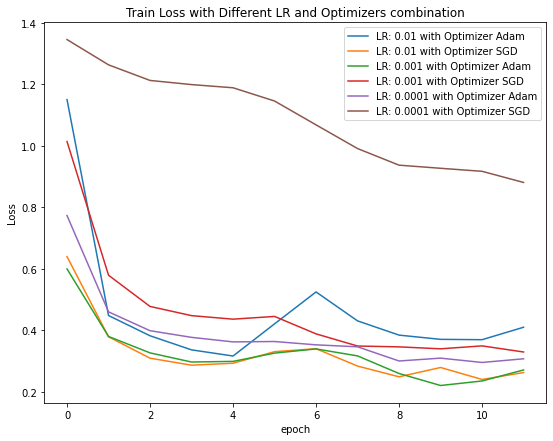

In [14]:
plt.figure(figsize=(9,7))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Train Loss with Different LR and Optimizers combination')

for learning_rate in hyper_parameters["learning_rate"]:
   for optimizer in hyper_parameters["optimizers"]:

     plt.plot([i for i in range(len(train_loss_hyper_parameters[f'lr{learning_rate}{optimizer}']))], train_loss_hyper_parameters[f'lr{learning_rate}{optimizer}'],label=f'LR: {learning_rate} with Optimizer {optimizer}')
    
plt.legend()

**Plot Train Accuracy with Different LR and Optimizers combination**

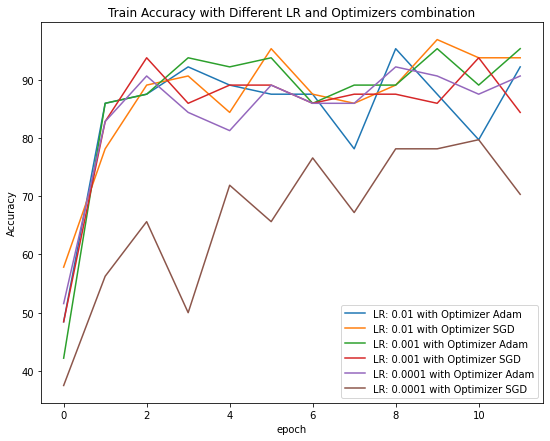

In [17]:
plt.figure(figsize=(9,7))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy with Different LR and Optimizers combination')

for learning_rate in hyper_parameters["learning_rate"]:
   for optimizer in hyper_parameters["optimizers"]:

     plt.plot([i for i in range(len(train_acc_hyper_parameters[f'lr{learning_rate}{optimizer}']))], train_acc_hyper_parameters[f'lr{learning_rate}{optimizer}'],label=f'LR: {learning_rate} with Optimizer {optimizer}')
    
plt.legend()

**Plot Validation Loss with Different LR and Optimizers combination**

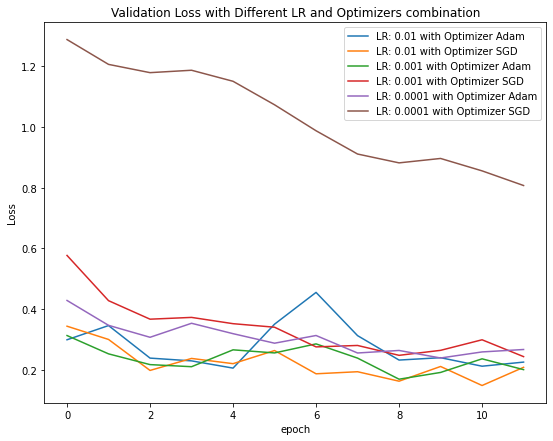

In [18]:
plt.figure(figsize=(9,7))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Validation Loss with Different LR and Optimizers combination')

for learning_rate in hyper_parameters["learning_rate"]:
   for optimizer in hyper_parameters["optimizers"]:

     plt.plot([i for i in range(len(val_loss_hyper_parameters[f'lr{learning_rate}{optimizer}']))], val_loss_hyper_parameters[f'lr{learning_rate}{optimizer}'],label=f'LR: {learning_rate} with Optimizer {optimizer}')
    
plt.legend()

**Plot Validation Accuracy with Different LR and Optimizers combination**

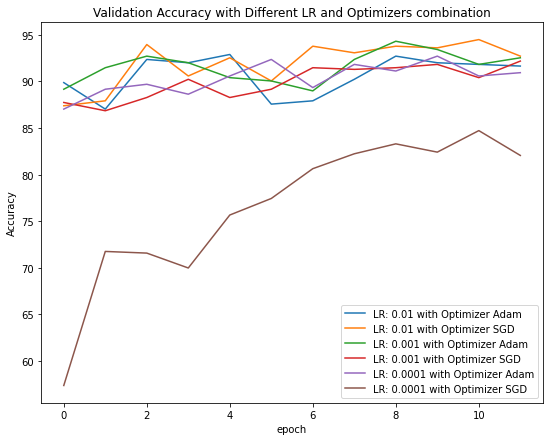

In [20]:
plt.figure(figsize=(9,7))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy with Different LR and Optimizers combination')

for learning_rate in hyper_parameters["learning_rate"]:
   for optimizer in hyper_parameters["optimizers"]:

     plt.plot([i for i in range(len(val_acc_hyper_parameters[f'lr{learning_rate}{optimizer}']))], val_acc_hyper_parameters[f'lr{learning_rate}{optimizer}'],label=f'LR: {learning_rate} with Optimizer {optimizer}')
    
plt.legend()